# Was a website redesign successful?
![](img/webpage-redesign-test.jpg)

*A [DataCamp](https://datacamp.com) challenge* &nbsp;&nbsp;&nbsp;&nbsp;{octicon}`calendar` May, 2023  

{bdg-primary-line}`A/B testing`

## The project
You work for an early-stage startup in Germany. Your team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site. 

They have been testing the changes for a few weeks and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if it is statistically significant.

The team assembled the following data file:

- `treatment` - "yes" if the user saw the new version of the landing page, no otherwise.
- `new_images` - "yes" if the page used a new set of images, no otherwise.
- `converted` - 1 if the user joined the site, 0 otherwise.

The control group is those users with "no" in both columns: the old version with the old set of images.

Complete the following tasks:

1. Analyze the conversion rates for each of the four groups: the new/old design of the landing page and the new/old pictures.
2. Can the increases observed be explained by randomness?
3. Which version of the website should they use?

In [1]:
# Import packages
import arviz as az
import matplotlib.pyplot as plt
import my_functions as my
import numpy as np
import pandas as pd
import seaborn as sns

# Read tha data
conv = pd.read_csv("data/redesign.csv")
print(conv)

      treatment new_images  converted
0           yes        yes          0
1           yes        yes          0
2           yes        yes          0
3           yes         no          0
4            no        yes          0
...         ...        ...        ...
40479        no         no          0
40480       yes        yes          0
40481       yes        yes          0
40482        no         no          0
40483       yes        yes          0

[40484 rows x 3 columns]


## Data validation

In [2]:
# Show info
conv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


Let's see if the four groups are equally represented in the data.

In [3]:
# Check the counts distribution of different groups
conv[["treatment", "new_images"]].value_counts(normalize=True)

treatment  new_images
no         no            0.25
           yes           0.25
yes        no            0.25
           yes           0.25
Name: proportion, dtype: float64

Yes, they are. They are equally represented so it will help reduce bias.

## Data analysis

I will calculate the conversion rates for each group.

In [4]:
conv.pivot_table(index=["treatment", "new_images"], values="converted", aggfunc="mean")

converted
treatment new_images           
no        no           0.107104
          yes          0.112538
yes       no           0.120047
          yes          0.113724

Let's visualize these values in a graph.

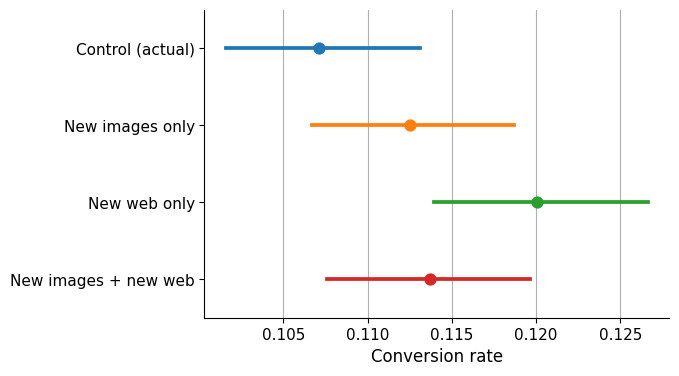

In [5]:
# Create arrays with the values of each group
webold_imgold = conv.loc[
    (conv["treatment"] == "no") & (conv["new_images"] == "no"), "converted"
].to_numpy()
webold_imgnew = conv.loc[
    (conv["treatment"] == "no") & (conv["new_images"] == "yes"), "converted"
].to_numpy()
webnew_imgold = conv.loc[
    (conv["treatment"] == "yes") & (conv["new_images"] == "no"), "converted"
].to_numpy()
webnew_imgnew = conv.loc[
    (conv["treatment"] == "yes") & (conv["new_images"] == "yes"), "converted"
].to_numpy()

# Create dataframe to plot in seaborn and show confidence intervals
webold_imgold_df = pd.DataFrame(
    {"group": "Control (actual)", "converted": webold_imgold}
)
webold_imgnew_df = pd.DataFrame(
    {"group": "New images only", "converted": webold_imgnew}
)
webnew_imgold_df = pd.DataFrame({"group": "New web only", "converted": webnew_imgold})
webnew_imgnew_df = pd.DataFrame(
    {"group": "New images + new web", "converted": webnew_imgnew}
)
conv_by_group = pd.concat(
    [webold_imgold_df, webold_imgnew_df, webnew_imgold_df, webnew_imgnew_df]
)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

sns.pointplot(
    ax=ax,
    x="converted",
    y="group",
    data=conv_by_group,
    order=[
        "Control (actual)",
        "New images only",
        "New web only",
        "New images + new web",
    ],
    hue="group",
    palette="tab10",
)

ax.grid(axis="x")
ax.set_axisbelow(True)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)
ax.set_xlabel("Conversion rate", size=12)
ax.set_ylabel("", size=11)
sns.despine()

plt.show()

This is what we can see:
- **Control (actual)**: The control group has the lowest conversion rate among the four groups.
- **New images only**: If new images are displayed in the same webpage design, the conversion rate increases, but the confidence intervals overlap with the control group, suggesting that the difference may not be significant.
- **New web only**: There appears to be a clearer difference in comparison to the control group if the new website design is presented *but* the images remain unchanged.
- **New images + new web**: Conversion rate confidence interval overlaps clearly with the control group.


## Hypothesis testing
I will calculate the mean-value distributions and represent them in a graph.

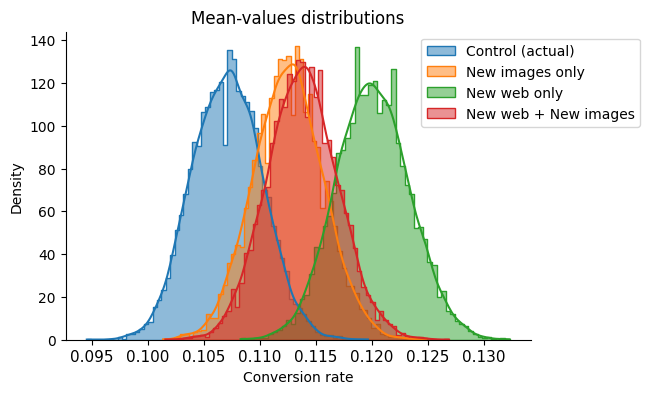

In [6]:
# Set random number seed
np.random.seed(42)

# Draw bootstrap replicates and store their mean values
bs_reps_webold_imgold = my.draw_bs_reps(webold_imgold, np.mean, size=10000)
bs_reps_webold_imgnew = my.draw_bs_reps(webold_imgnew, np.mean, size=10000)
bs_reps_webnew_imgold = my.draw_bs_reps(webnew_imgold, np.mean, size=10000)
bs_reps_webnew_imgnew = my.draw_bs_reps(webnew_imgnew, np.mean, size=10000)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    bs_reps_webold_imgold,
    ax=ax,
    kde=True,
    stat="density",
    element="step",
    label="Control (actual)",
)
sns.histplot(
    bs_reps_webold_imgnew,
    ax=ax,
    kde=True,
    stat="density",
    element="step",
    label="New images only",
)
sns.histplot(
    bs_reps_webnew_imgold,
    ax=ax,
    kde=True,
    stat="density",
    element="step",
    label="New web only",
)
sns.histplot(
    bs_reps_webnew_imgnew,
    ax=ax,
    kde=True,
    stat="density",
    element="step",
    label="New web + New images",
)

ax.set_title("Mean-values distributions", size=12)
ax.tick_params(axis="x", labelsize=11, rotation=0)
ax.tick_params(axis="y", labelsize=10)
ax.set_xlabel("Conversion rate", size=10)
ax.legend(loc="upper left", bbox_to_anchor=(0.75, 1), fontsize=10)
sns.despine()

plt.show()

As with the previous graph, it appears that the 95% confidence interval of the control group does not overlap with that of the "New web only" version of the page, but a hypothesis test is necessary to confirm this.


The null hypothesis I will consider is that the differences in mean values are purely due to chance, with all groups having the same distribution of mean values.

I will define a function that performs the following tasks:
1. Takes two measurement arrays and calculates the difference of their mean values.
2. Concatenates those measurement arrays in a single array to calculate combined mean value.
3. Shifts each array's values to have the same combined mean.
4. Computes 10,000 bootstrap replicates, storing the mean of each of them.
5. Checks all 10,000 mean values to see how many of them resulted in a difference equal to or greater than the one we measured. Dividing by the number of samples (10,000) will give us the p-value.

In [7]:
# Define function
def cal_p_value(arrayh, arrayl):
    """Calculates p-value by bootstrapping arrays and getting mean differences"""

    # Compute the difference of means
    diff_means = np.mean(arrayh) - np.mean(arrayl)

    # Concatenate arrays
    concat = np.concatenate((arrayh, arrayl))

    # Compute mean of all
    mean_concat = np.mean(concat)

    # Generate shifted arrays
    arrayh_shifted = arrayh - np.mean(arrayh) + mean_concat
    arrayl_shifted = arrayl - np.mean(arrayl) + mean_concat

    # Compute 10,000 bootstrap replicates from shifted arrays
    bs_reps_arrayh_shifted = my.draw_bs_reps(arrayh_shifted, np.mean, size=10000)
    bs_reps_arrayl_shifted = my.draw_bs_reps(arrayl_shifted, np.mean, size=10000)

    # Get replicates of difference of means
    bs_reps_diff = bs_reps_arrayh_shifted - bs_reps_arrayl_shifted

    # Compute p-value
    p = np.sum(bs_reps_diff >= diff_means) / len(bs_reps_diff)

    return p


# Calculate p-value of only new images
p_webold_imgnew = cal_p_value(webold_imgnew, webold_imgold)
print(f"\n{p_webold_imgnew} <- p-value 'New images' only")

# Calculate p-value of only new webpage
p_webnew_imgold = cal_p_value(webnew_imgold, webold_imgold)
print(f"\n{p_webnew_imgold} <- p-value 'New webpage' only")

# Calculate p-value of new webpage + new images
p_webnew_imgnew = cal_p_value(webnew_imgnew, webold_imgold)
print(f"\n{p_webnew_imgnew} <- p-value 'New webpage + New images'\n")


0.1059 <- p-value 'New images' only

0.0019 <- p-value 'New webpage' only

0.0692 <- p-value 'New webpage + New images'



The lowest p-value obtained was 0.0019 (0.19%), which is lower than a standard significance level of 5%. This indicates that out of 10,000 random tests, only 19 of them resulted in a difference in mean values equal to or greater than the one we observed. This is a very small number, suggesting that it would occur very rarely. Therefore, we can reject the null hypothesis in this case and conclude that the difference in the conversion rate is likely due to the difference in the web page design without new images.

In the other two, the p-values of 0.069 (6.7%) and 0.1059 (10.59%) indicate that there are higher chances of having those differences occur by chance. As they are above the significance level of 5%, we will not draw the same conclusion as before and we fail to reject the null hypothesis in these cases.

## Bayesian approach
We will evaluate the problem using the Bayesian approach to obtain more information.

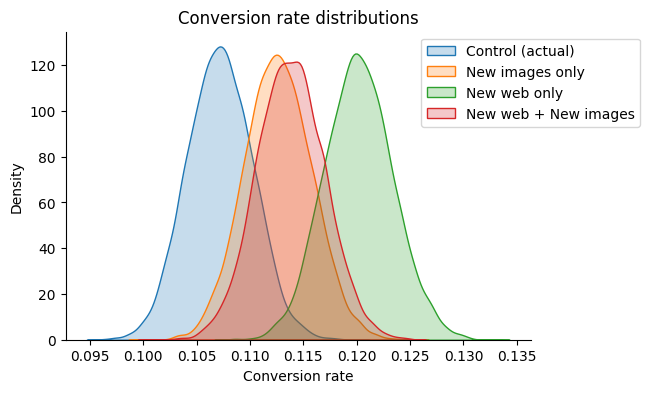

In [8]:
# Define function to claculate posterior beta distribution
def simulate_beta_posterior(trials, beta_prior_a, beta_prior_b, size=10000):
    num_successes = np.sum(trials)
    posterior_draws = np.random.beta(
        num_successes + beta_prior_a, len(trials) - num_successes + beta_prior_b, size
    )
    return posterior_draws


# No prior knowledge assumed
a, b = 1, 1

# Simulate posterior draws for each case
webold_imgold_posterior = simulate_beta_posterior(webold_imgold, a, b)
webold_imgnew_posterior = simulate_beta_posterior(webold_imgnew, a, b)
webnew_imgold_posterior = simulate_beta_posterior(webnew_imgold, a, b)
webnew_imgnew_posterior = simulate_beta_posterior(webnew_imgnew, a, b)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(webold_imgold_posterior, ax=ax, fill=True, label="Control (actual)")
sns.kdeplot(webold_imgnew_posterior, ax=ax, fill=True, label="New images only")
sns.kdeplot(webnew_imgold_posterior, ax=ax, fill=True, label="New web only")
sns.kdeplot(webnew_imgnew_posterior, ax=ax, fill=True, label="New web + New images")
ax.set_title("Conversion rate distributions", size=12)
ax.set_xlabel("Conversion rate", size=10)
ax.legend(loc="upper left", bbox_to_anchor=(0.75, 1), fontsize=10)
sns.despine()
plt.show()

It is more probable that "New web only" option is better. Let's check how sure we are about it.

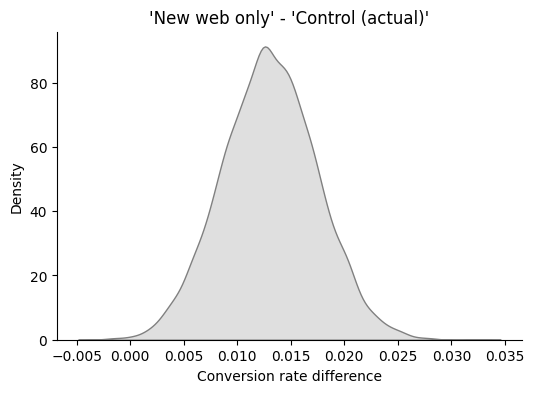

In [15]:
# Calculate posterior difference and plot it
diff = webnew_imgold_posterior - webold_imgold_posterior
fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(diff, ax=ax, fill=True, label="diff", color="grey")
ax.set_title("'New web only' - 'Control (actual)'", size=12)
ax.set_xlabel("Conversion rate difference", size=10)
sns.despine()
plt.show()

In [14]:
# Calculate 90% credible interval of posterior difference
interval = az.hdi(diff, hdi_prob=0.9)
print(
    f"The probability that 'New web only' option's true click-rate increase lies between {100 * interval[0]:.1f}% and {100 * interval[1]:.1f}% is 90%."
)

The probability that 'New web only' option's true click-rate increase lies between 0.6% and 2.0% is 90%.


In [11]:
# Calculate probability of "New web only" option being better
new_web_opt_prob = (diff > 0).mean()
print(
    f"The probability that the 'New web only' option click rate is higher is {100 * new_web_opt_prob:.1f}%."
)
print(
    f"The risk of being this a wrong decision is therefore {100 * (1-new_web_opt_prob):.1f}%."
)

The probability that the 'New web only' option click rate is higher is 99.9%.
The risk of being this a wrong decision is therefore 0.1%.


In [12]:
# Slice diff to take only cases where it is negative
loss = diff[diff < 0]

# Compute and print expected loss
expected_loss = loss.mean()
print(
    f"Even if the wrong decision materializes, we will only lose {100 * abs(expected_loss):.2f}% of click rates."
)

Even if the wrong decision materializes, we will only lose 0.10% of click rates.


## Conclusion
They should definitely use **the new version of the landing webpage without the new set of images**.